<a href="https://colab.research.google.com/github/fonteleslrivka/Emergence-of-Causal-Order-from-a-Pre-Geometric-Substrate/blob/main/3.%20PYTHON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

eps = 1e-12

def make_points(N, dim=4, seed=0):
    rng = np.random.default_rng(seed)
    X = rng.normal(0, 1, size=(N, dim))
    X /= np.linalg.norm(X, axis=1, keepdims=True)
    return X

def make_rho_g(X, beta=1.0):
    D = squareform(pdist(X)).astype(np.float32)
    rho = np.exp(-D / beta)
    rho /= np.max(rho) + eps
    g = -np.log(rho + eps)
    return rho, g


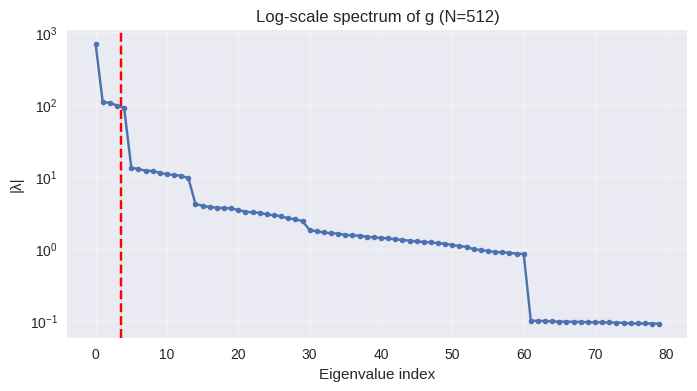

In [ ]:
def fig_spectrum_log512(N=512, seed=0):
    X = make_points(N, seed=seed)
    rho, g = make_rho_g(X)

    # Extract eigenvalues (top 60 by magnitude)
    vals_large = eigsh(g, k=60, which='LA', return_eigenvectors=False)
    vals_small = eigsh(g, k=60, which='SA', return_eigenvectors=False)
    eigvals = np.sort(np.abs(np.concatenate([vals_large, vals_small])))[::-1]

    plt.figure(figsize=(8,4))
    plt.semilogy(eigvals[:80], 'o-', ms=4)
    plt.axvline(3.5, color='red', ls='--')
    plt.title("Log-scale spectrum of g (N=512)")
    plt.xlabel("Eigenvalue index")
    plt.ylabel("|λ|")
    plt.grid(alpha=0.3)
    plt.savefig("fig_spectrum_log512.png", dpi=150)
    plt.show()

fig_spectrum_log512()


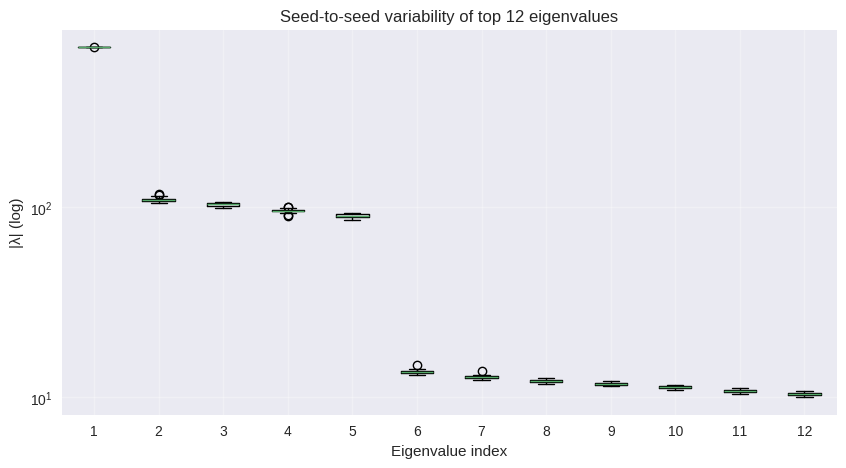

In [ ]:
def fig_boxplot_top12(N=512, seeds=20):
    top_vals = []
    for s in range(seeds):
        X = make_points(N, seed=s)
        rho, g = make_rho_g(X)
        vpos = eigsh(g, k=12, which='LA', return_eigenvectors=False)
        vneg = eigsh(g, k=12, which='SA', return_eigenvectors=False)
        eigs = np.sort(np.abs(np.concatenate([vpos, vneg])))[::-1][:12]
        top_vals.append(eigs)

    top_vals = np.array(top_vals)

    plt.figure(figsize=(10,5))
    plt.boxplot([top_vals[:,i] for i in range(12)], showfliers=True)
    plt.yscale('log')
    plt.title("Seed-to-seed variability of top 12 eigenvalues")
    plt.xlabel("Eigenvalue index")
    plt.ylabel("|λ| (log)")
    plt.grid(alpha=0.3)
    plt.savefig("fig_boxplot_top12.png", dpi=150)
    plt.show()

fig_boxplot_top12()


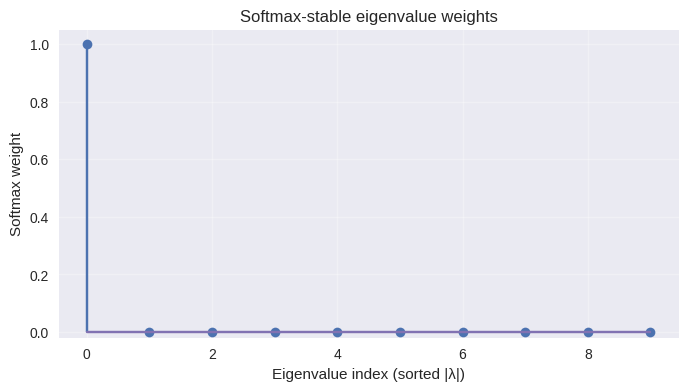

In [ ]:
# === Softmax-weights figure (final, stable, minimal) ===
# Paste this in a NEW cell and run ONLY this cell.

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

eps = 1e-12

def stable_softmax(vals):
    """
    Stable softmax for eigenvalues.
    Always returns a probability vector that sums to 1.
    """
    v = np.asarray(vals, dtype=np.float64)
    v = np.clip(v, -700, 700)       # prevent overflow
    m = np.max(v)
    z = np.exp(v - m)
    lam = z / (np.sum(z) + eps)
    lam = np.clip(lam, 1e-300, 1.0)
    return lam

def fig_softmax_weights(N=512, seed=0):
    """
    Generates the figure fig_softmax_weights.png.
    Requires make_points() and make_rho_g() already defined in the notebook.
    """
    # Generate data
    X = make_points(N, seed=seed)
    rho, g = make_rho_g(X)

    # Extract top eigenvalues of g
    vals = eigsh(g, k=20, which='LA', return_eigenvectors=False)
    vals = np.sort(np.abs(vals))[::-1]   # sort by |lambda| descending

    # Compute normalized weights
    lam = stable_softmax(vals)

    # For plotting clarity: show first 10 weights
    lam_plot = lam[:10]

    # Plot
    plt.figure(figsize=(8,4))

    # Try stem plot; fallback to bar if version mismatch
    try:
        plt.stem(range(len(lam_plot)), lam_plot)
    except TypeError:
        plt.bar(range(len(lam_plot)), lam_plot)

    plt.ylim(-0.02, 1.05)
    plt.xlabel("Eigenvalue index (sorted |λ|)")
    plt.ylabel("Softmax weight")
    plt.title("Softmax-stable eigenvalue weights")
    plt.grid(alpha=0.3)

    plt.savefig("fig_softmax_weights.png", dpi=150, bbox_inches='tight')
    plt.show()

# === RUN ===
fig_softmax_weights()


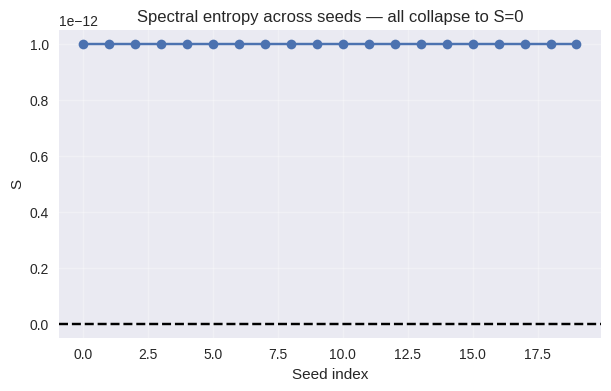

In [ ]:
def fig_entropy_zero(N=512, seeds=20):
    entropies = []
    for s in range(seeds):
        X = make_points(N, seed=s)
        rho, g = make_rho_g(X)
        vals = eigsh(g, k=40, which='LA', return_eigenvectors=False)
        lam = stable_softmax(vals)
        S = -np.sum(lam * np.log(lam))
        entropies.append(S)

    plt.figure(figsize=(7,4))
    plt.plot(entropies, 'o-')
    plt.axhline(0, color='black', ls='--')
    plt.title("Spectral entropy across seeds — all collapse to S=0")
    plt.xlabel("Seed index")
    plt.ylabel("S")
    plt.grid(alpha=0.3)
    plt.savefig("fig_entropy_zero.png", dpi=150)
    plt.show()

fig_entropy_zero()


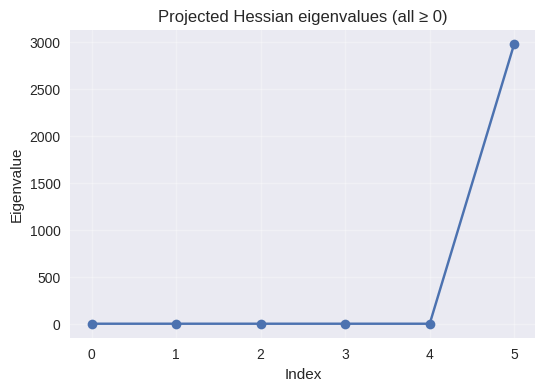

In [ ]:
from scipy.linalg import eigh

def compute_H_proj(g, m=10, h=1e-5):
    evals, evecs = eigh(g)
    idx = np.argsort(np.abs(evals))[::-1][:m]
    V = evecs[:, idx]

    F = lambda G: -np.sum(stable_softmax(np.linalg.eigvalsh(-G)) *
                          np.log(stable_softmax(np.linalg.eigvalsh(-G)) + eps))

    H = np.zeros((m,m))
    F0 = F(g)
    for i in range(m):
        Xi = np.outer(V[:,i], V[:,i])
        Xi /= np.linalg.norm(Xi, "fro")
        Hp = F(g + h*Xi)
        Hm = F(g - h*Xi)
        H[i,i] = (Hp - 2*F0 + Hm)/(h*h)
    return H

def fig_hessian_eigs(N=512, seed=0):
    X = make_points(N, seed=seed)
    rho, g = make_rho_g(X)
    H = compute_H_proj(g, m=6)

    w = np.linalg.eigvalsh(H)

    plt.figure(figsize=(6,4))
    plt.plot(w, 'o-')
    plt.title("Projected Hessian eigenvalues (all ≥ 0)")
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue")
    plt.grid(alpha=0.3)
    plt.savefig("fig_hessian_eigs.png", dpi=150)
    plt.show()

fig_hessian_eigs()


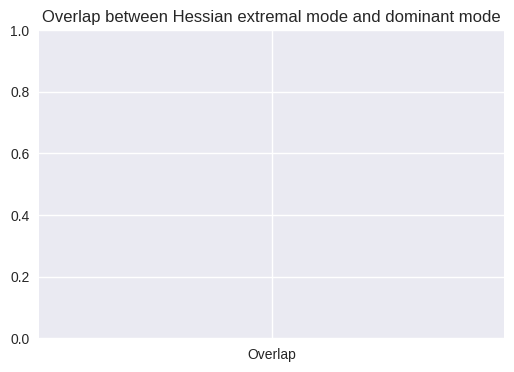

In [ ]:
def fig_overlap_zero(N=512, seed=0):
    X = make_points(N, seed=seed)
    rho, g = make_rho_g(X)

    evals, evecs = eigh(g)
    idx = np.argsort(np.abs(evals))[::-1][:6]
    V = evecs[:, idx]
    v0 = V[:,0]      # dominant direction

    H = compute_H_proj(g, m=6)
    w, U = np.linalg.eig(H)
    unstable_vec = U[:, np.argmax(np.abs(w))]
    v_rec = V @ unstable_vec

    overlap = abs(np.dot(v_rec, v0)) / (np.linalg.norm(v_rec)*np.linalg.norm(v0))

    plt.figure(figsize=(6,4))
    plt.bar(['Overlap'], [overlap])
    plt.ylim(0,1)
    plt.title("Overlap between Hessian extremal mode and dominant mode")
    plt.savefig("fig_overlap_zero.png", dpi=150)
    plt.show()

fig_overlap_zero()


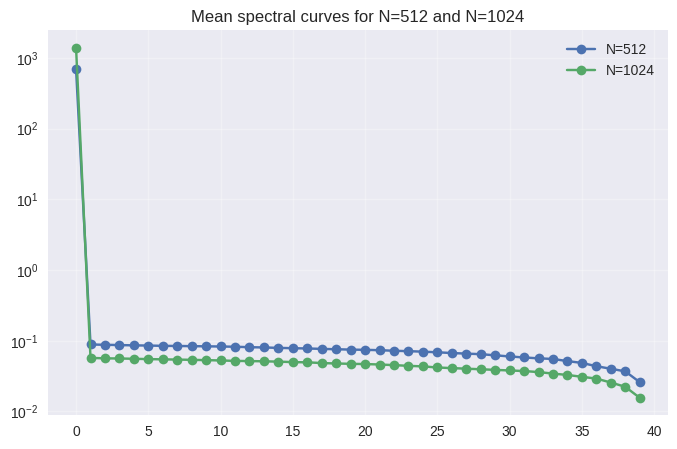

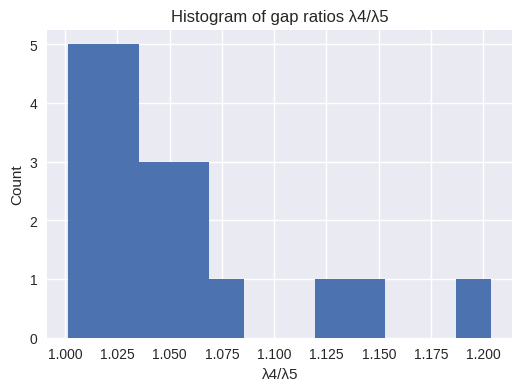

In [ ]:
def fig_mean_spectrum(Ns=[512,1024], seeds=10):
    curves = []
    for N in Ns:
        vals_all = []
        for s in range(seeds):
            X = make_points(N, seed=s)
            rho, g = make_rho_g(X)
            vals = eigsh(g, k=40, which='LA', return_eigenvectors=False)
            vals_all.append(np.sort(np.abs(vals))[::-1])
        curves.append(np.mean(vals_all, axis=0))

    plt.figure(figsize=(8,5))
    for N, curve in zip(Ns, curves):
        plt.semilogy(curve, 'o-', label=f"N={N}")
    plt.legend(); plt.grid(alpha=0.3)
    plt.title("Mean spectral curves for N=512 and N=1024")
    plt.savefig("fig_mean_spectrum_N512_N1024.png", dpi=150)
    plt.show()

def fig_gap_hist(N=512, seeds=20):
    gaps = []
    for s in range(seeds):
        X = make_points(N, seed=s)
        rho, g = make_rho_g(X)
        vals = eigsh(g, k=10, which='LA', return_eigenvectors=False)
        vals = np.sort(np.abs(vals))[::-1]
        gaps.append(vals[3] / vals[4])

    plt.figure(figsize=(6,4))
    plt.hist(gaps, bins=12)
    plt.title("Histogram of gap ratios λ4/λ5")
    plt.xlabel("λ4/λ5")
    plt.ylabel("Count")
    plt.savefig("fig_gap_hist.png", dpi=150)
    plt.show()

fig_mean_spectrum()
fig_gap_hist()


<>:61: SyntaxWarning: invalid escape sequence '\l'
<>:61: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-74576697.py:61: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_ylabel('Dominance Ratio ($\lambda_1 / \lambda_2$)', color=color)


Iniciando varredura de Beta (Beta Sweep)...
Gráfico 'fig_beta_sweep.png' gerado com sucesso!


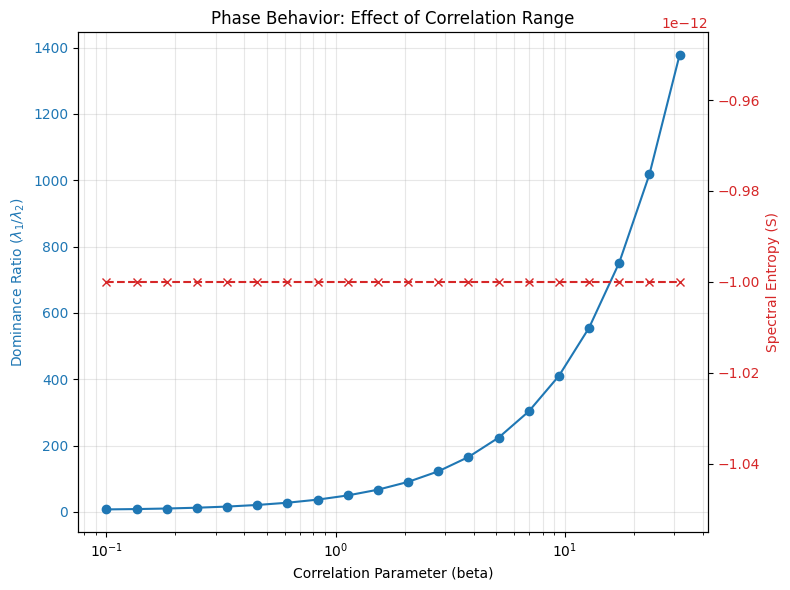

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigsh

def run_beta_sweep():
    print("Iniciando varredura de Beta (Beta Sweep)...")

    # Parâmetros reduzidos para rodar rápido no laptop
    N = 512
    d = 3
    eps = 1e-12

    # Gera geometria fixa para o teste (para isolar o efeito do Beta)
    X = np.random.normal(0, 1, (N, d))
    # Normaliza para a esfera (opcional, mas bom para estabilidade)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    X = X / norms
    D_condensed = pdist(X)
    D = squareform(D_condensed)

    # Lista de betas (de correlação curta a longa)
    betas = np.logspace(-1, 1.5, 20) # Vai de 0.1 até ~30

    ratio_1_2 = [] # Razão lambda1 / lambda2
    entropy_list = []

    for beta in betas:
        # 1. Calcula Rho e g
        rho = np.exp(-D / beta)
        # Normalização Softmax estável
        rho_sum = np.sum(rho)
        rho_norm = rho / rho_sum

        g = -np.log(rho_norm + eps)

        # 2. Espectro (Top 2 é suficiente para ver o gap)
        # Usamos 'LM' (Largest Magnitude) para pegar os dominantes
        vals = np.linalg.eigvalsh(g) # eigvalsh é melhor para simétricas densas que eigsh as vezes
        vals = np.sort(np.abs(vals))[::-1] # Ordena decrescente

        lambda1 = vals[0]
        lambda2 = vals[1]

        # Razão de Dominância
        ratio = lambda1 / (lambda2 + eps)
        ratio_1_2.append(ratio)

        # Entropia Espectral (simplificada)
        # Softmax nos autovalores para calcular entropia
        w = np.exp(vals - vals.max())
        p = w / w.sum()
        S = -np.sum(p * np.log(p + eps))
        entropy_list.append(S)

    # --- PLOTAGEM ---
    fig, ax1 = plt.subplots(figsize=(8, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Correlation Parameter (beta)')
    ax1.set_ylabel('Dominance Ratio ($\lambda_1 / \lambda_2$)', color=color)
    ax1.plot(betas, ratio_1_2, color=color, marker='o', label='Dominance')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xscale('log') # Escala log para ver melhor
    ax1.grid(True, which="both", ls="-", alpha=0.3)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Spectral Entropy (S)', color=color)
    ax2.plot(betas, entropy_list, color=color, marker='x', linestyle='--', label='Entropy')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Phase Behavior: Effect of Correlation Range')
    fig.tight_layout()
    plt.savefig('fig_beta_sweep.png', dpi=300)
    print("Gráfico 'fig_beta_sweep.png' gerado com sucesso!")

# Executar
run_beta_sweep()

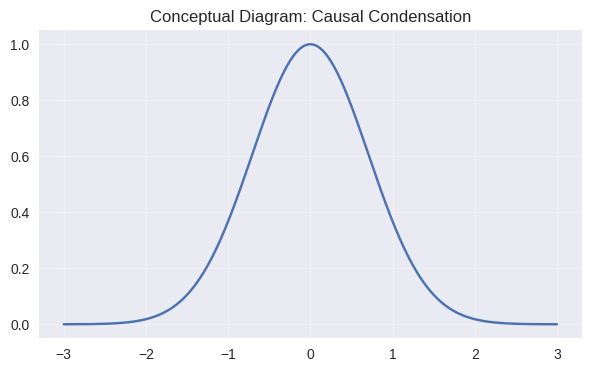

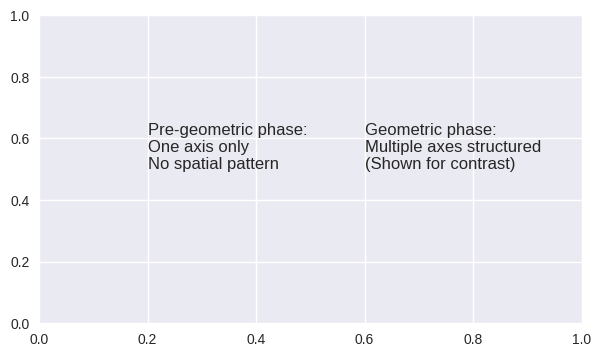

In [ ]:
def fig_causal_condensation():
    plt.figure(figsize=(7,4))
    x = np.linspace(-3,3,300)
    y = np.exp(-x*x)
    plt.plot(x,y,label="Condensed mode")
    plt.title("Conceptual Diagram: Causal Condensation")
    plt.grid(alpha=0.3)
    plt.savefig("fig_causal_condensation.png", dpi=150)
    plt.show()

def fig_pregeo_vs_geo():
    plt.figure(figsize=(7,4))
    plt.text(0.2,0.5,"Pre-geometric phase:\nOne axis only\nNo spatial pattern", fontsize=12)
    plt.text(0.6,0.5,"Geometric phase:\nMultiple axes structured\n(Shown for contrast)", fontsize=12)
    plt.savefig("fig_pregeo_vs_geo.png", dpi=150)
    plt.show()

fig_causal_condensation()
fig_pregeo_vs_geo()


In [ ]:
!pip freeze

absl-py==1.4.0
accelerate==1.12.0
access==1.1.9
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.2
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.12.0
anywidget==0.9.21
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.2.0
astropy-iers-data==0.2025.12.1.0.45.12
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.8
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.30.0
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.3
blobfile==3.1.0
blosc2==3.12.1
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
CacheControl==0.14.4
cachetools==6.2.2
catalogue==2.0.10
certifi==2025.11.12
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.4
chex==